In [101]:
import pypsa
import pandas as pd
import pypsa
import numpy as np
import os
import matplotlib.pyplot as plt

run_name = "tango_sweep"


In [64]:
data = pd.read_csv(csvdir+'supply'+'.csv',skiprows=lambda x: x in [0,1,2,4])



noscaling  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              31054.963365   
                                     offwind-dc                              58708.288903   
                                     onwind                                 810231.172120   
                                     ror                                     42350.018595   
                                     solar                                  927373.162785   
...                                                                                   ...   
urban central heat        loads      low-temperature heat for industry       -6747.568795   
                                     urban central heat                    -561517.935981   
urban central water tanks links      urban central water tanks charger1     308633.903334   
                                     urban central water tanks discharger0 -336466.388464   
                          stores     urban central water tanks              326002.739022   

                                                                              Tango_1of10  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              31017.734917   
                                     offwind-dc                              54619.874667   
                                     onwind                                 792233.914790   
                                     ror                                     42349.862919   
                                     solar                                  823818.838682   
...                                                                                   ...   
urban central heat        loads      low-temperature heat for industry       -6511.549935   
                                     urban central heat                    -524788.274015   
urban central water tanks links      urban central water tanks charger1     255252.040476   
                                     urban central water tanks discharger0 -253523.611684   
                          stores     urban central water tanks              240439.192957   

                                                                              Tango_2of10  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              29225.274301   
                                     offwind-dc                              54640.533885   
                                     onwind                                 768742.844870   
                                     ror                                     42350.046801   
                                     solar                                  726572.411090   
...                                                                                   ...   
urban central heat        loads      low-temperature heat for industry       -6275.531075   
                                     urban central heat                    -488058.612050   
urban central water tanks links      urban central water tanks charger1     205201.249689   
                                     urban central water tanks discharger0 -202812.212718   
                          stores     urban central water tanks              192155.795138   

                                                                              Tango_3of10  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              24561.835562   
                                     offwind-dc                              48660.177327   
                                     onwind                                 72

In [75]:
# First, just mess around with csvs

def load_data(file):
    csvdir = 'results/'+run_name+'/csvs/'
    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    return data

def normalize_csv(file):
    csvdir = 'results/'+run_name+'/csvs/'
    outdir = "postanalysis/"

    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    datanorm = data.divide(data['noscaling'],axis=0)
    if not os.path.exists(os.getcwd()+'/'+csvdir+outdir):
        os.mkdir(os.getcwd()+'/'+csvdir+outdir)
    datanorm.to_csv(csvdir+outdir+file+'_normalized.csv',float_format="%.4f")
    

In [69]:
normalize_csv("supply")
normalize_csv("capacities")
normalize_csv("energy")


In [82]:
c=load_data("costs")
totc=pd.DataFrame(c.sum())
totc["ratio"] = totc.divide(totc.loc["noscaling"][0],axis=0)
totc.columns = ['total','ratio']
totc.to_csv(csvdir+outdir+"total_costs.csv")
totc

,total,ratio
noscaling,6.592962e+11,1.000000
Tango_1of10,6.193216e+11,0.939368
Tango_2of10,5.805828e+11,0.880610
Tango_3of10,5.431158e+11,0.823781
Tango_4of10,5.064962e+11,0.768238
Tango_5of10,4.703414e+11,0.713399
Tango_6of10,4.350864e+11,0.659925
Tango_7of10,4.019627e+11,0.609684
Tango_8of10,3.706806e+11,0.562237
Tango_9of10,3.406535e+11,0.516693


# Gas limits

In [203]:
n = pypsa.Network("results/tango_sweep/postnetworks/elec_sc_noscaling_s_37_lvopt__Co2L0p01-96H-T-H-B-I-A-solar+p3-dist1_2050.nc")
n1 = pypsa.Network("results/tango_sweep/postnetworks/elec_sc_Tango_10of10_s_37_lvopt__Co2L0p01-96H-T-H-B-I-A-solar+p3-dist1_2050.nc")
nold = pypsa.Network("results/220715_Co2_05pct/postnetworks/elec_sc_noscaling_s_37_lv2__Co2L0p05-96H-T-H-B-I-A-solar+p2-dist1_2030.nc")

INFO:pypsa.io:Imported network elec_sc_noscaling_s_37_lvopt__Co2L0p01-96H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_sc_Tango_10of10_s_37_lvopt__Co2L0p01-96H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_sc_noscaling_s_37_lv2__Co2L0p05-96H-T-H-B-I-A-solar+p2-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [152]:
n_elec = pypsa.Network("../pypsa-eur/results/networks/elec_s_37_ec_lcopt_Co2L-CH4L100-96H.nc")
n_elec.carriers.index.intersection(["gas","biogas"])

#n_elec.carriers
#n_elec.generators_t


INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_Co2L-CH4L100-96H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Index([], dtype='object', name='Carrier')

In [178]:
supply_energy = load_data("supply_energy")
gas_supply_nrg = supply_energy.loc["gas"]/1e6
gas_buses = n.buses.loc[[i for i in n.buses.index if n.buses.loc[i]["carrier"]=="gas"]]
gas_buses.columns
#print(n.generators.loc[[i for i in n.generators.index if "gas" in i]]['p_nom_opt'])
#print(n1.generators.loc[[i for i in n.generators.index if "gas" in i]]['p_nom_opt'])

Index(['v_nom', 'x', 'y', 'country', 'control', 'generator', 'carrier',
       'location', 'unit', 'type', 'v_mag_pu_set', 'v_mag_pu_min',
       'v_mag_pu_max', 'sub_network'],
      dtype='object')

In [268]:
for c in n.iterate_components(n.one_port_components):
    if not c.name == "Generator":
        continue
    print(c.name)
    gens = c
gens.df.loc["EU gas"]["p_nom_opt"]
#gas_gens = gens.df[[i for i in gens.df.index if gens.df.loc[i]["carrier"]=="gas"]]
#gens.df.loc[[i for i in gens.df.index if gens.df.loc[i]["carrier"]=="gas"]]
gens.pnl.p["EU gas"].

Generator


snapshot
2013-01-01     62795.185100
2013-01-05     61927.267554
2013-01-09     61829.010847
2013-01-13     62658.712229
2013-01-17     65186.259738
                  ...      
2013-12-15     66144.832655
2013-12-19     65940.764968
2013-12-23     65057.612068
2013-12-27     64336.442339
2013-12-31    222026.606094
Name: EU gas, Length: 92, dtype: float64

In [231]:
print("n.generators_t sum : ",n.generators_t.p["EU gas"].sum()/1e6*96)
print("n.buses_t sum : ", n.buses_t.p["EU gas"].sum()*-1*96*1000)
supply_energy = load_data("supply_energy")
gas_supply_nrg = supply_energy.loc["gas"]/1e6
print("supply_energy.csv generators sum : ",gas_supply_nrg.loc["generators"]["noscaling"]["gas"])


n.generators_t sum :  610.1210531053983
n.buses_t sum :  702.097310917452
supply_energy.csv generators sum :  594.1351374666532


In [278]:
gaslinks = n.links.loc[[i for i in n.links.index if n.links.loc[i]["bus0"]=="EU gas" or n.links.loc[i]["bus1"]=="EU gas" ]]
#print(gaslinks.index)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(gaslinks[["bus0","bus1","efficiency","bus2","efficiency2"]])
#gaslinks[["bus0","efficiency","bus1","efficiency1","bus2","efficiency2","bus3","efficiency3"]]
#n.links_t.efficiency[gaslinks]

6355427.636514566
6.355427636514566


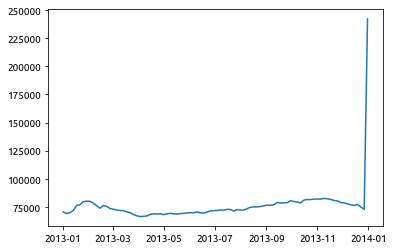

In [202]:
#[c for c in gens.pnl.p.columns if "gas" in c]

fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(n1.generators_t.p["EU gas"])
fig.savefig('gas.png')

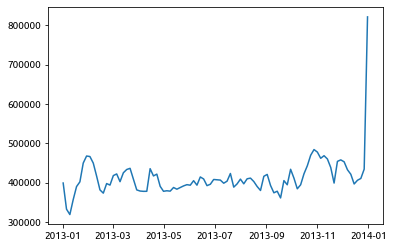

In [204]:
plt.plot(nold.generators_t.p["EU gas"])